## Load 
- DEM, shape(Road/Lake/River/Stream) --> extract slope and aspect from DEM --> generate mask for each shape
- 험지 지정

In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from rasterio.features import rasterize

# 1) Load DEM
with rasterio.open("battleground_clipped.tif") as src:
    dem       = src.read(1)
    transform = src.transform
    crs       = src.crs
    bounds    = src.bounds
height, width = dem.shape

# 2) Compute slope & aspect in geographic (lat/lon) coords
# 2a) build lon/lat grids
lon_vals = np.linspace(bounds.left,  bounds.right, width)
lat_vals = np.linspace(bounds.top,   bounds.bottom, height)
lon, lat = np.meshgrid(lon_vals, lat_vals)

# 2b) compute per-pixel distances (m)
lat_m = 111320.0
lon_m = 111320.0 * np.cos(np.radians(lat))
dy = lat_m * np.gradient(lat, axis=0)
dx = lon_m * np.gradient(lon, axis=1)

# 2c) compute elevation gradients
dz_dy = np.gradient(dem, axis=0) / dy
dz_dx = np.gradient(dem, axis=1) / dx

# 2d) slope (°)
slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)

# 2e) aspect (° clockwise from North)
aspect_rad = np.arctan2(dz_dx, -dz_dy)
aspect_deg = np.mod(np.degrees(aspect_rad) + 360.0, 360.0)

# 3) Read & clip vector layers
clip_box = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

road   = gpd.read_file("road/road.shp").to_crs(crs)
lake   = gpd.read_file("water/water.shp").to_crs(crs)
river  = gpd.read_file("waterways_river/waterways_river_100m.shp").to_crs(crs)
stream = gpd.read_file("waterways_stream/waterways_stream_5m.shp").to_crs(crs)

road_clip   = gpd.clip(road,   clip_box)
lake_clip   = gpd.clip(lake,   clip_box)
river_clip  = gpd.clip(river,  clip_box)
stream_clip = gpd.clip(stream, clip_box)

# 4) Rasterize masks (1=feature, 0=background)
road_mask = rasterize(
    [(geom, 1) for geom in road_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
lake_mask = rasterize(
    [(geom, 1) for geom in lake_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
river_mask = rasterize(
    [(geom, 1) for geom in river_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
stream_mask = rasterize(
    [(geom, 1) for geom in stream_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)

# 5) Golan Heights–specific ruggedness classification
#    1: gentle (0–10°), 2: moderate (10–25°), 3: steep (25–40°), 4: cliff (>40°)
ruggedness = np.zeros_like(slope_deg, dtype=np.uint8)
ruggedness[ slope_deg <= 10 ]              = 1
ruggedness[(slope_deg > 10) & (slope_deg <= 25)] = 2
ruggedness[(slope_deg > 25) & (slope_deg <= 40)] = 3
ruggedness[ slope_deg >  40 ]              = 4

# 6) Aspect categories (1=N, 2=E, 3=S, 4=W)
bins = [0, 45, 135, 225, 315, 360]
aspect_cat = np.digitize(aspect_deg, bins, right=False)
aspect_cat[aspect_cat == 5] = 1  # wrap 360→0→North

# 7) Define tactical masks
#  - wall_mask: cliff (>40°) & west-facing (W)
#  - assembly_mask: gentle/moderate & south-facing (S)
#  - advance_mask: gentle only
wall_mask     = (ruggedness == 4) & (aspect_cat == 4)
assembly_mask = ((ruggedness == 1) | (ruggedness == 2)) & (aspect_cat == 3)
advance_mask  = (ruggedness == 1)

# 8) Now you have:
#    dem, slope_deg, aspect_deg,
#    road_mask, lake_mask, river_mask, stream_mask,
#    ruggedness, aspect_cat,
#    wall_mask, assembly_mask, advance_mask
# each as a NumPy array with (0,0) at the top-left pixel.

| 배열명             | 설명                                     | 값/코드                                                     | 용도               |
| --------------- | -------------------------------------- | -------------------------------------------------------- | ---------------- |
| `dem`           | 원본 DEM의 고도 값                           | 실수 (m)                                                   | 고도 참조, 배경 데이터    |
| `slope_deg`     | 각 픽셀의 경사도                              | 실수 (0° \~ ≈90°)                                          | 지형 난이도 평가, 험지 분류 |
| `aspect_deg`    | 각 픽셀의 방위각 (북=0°, 시계방향 증가)              | 실수 (0° \~ 360°)                                          | 사면 방향 분석         |
| `road_mask`     | 도로 벡터를 래스터화한 이진 마스크                    | 1=도로, 0=비도로                                              | 도로 접근성 분석        |
| `lake_mask`     | 호수·정체 수역 벡터를 래스터화한 이진 마스크              | 1=호수/연못, 0=비수역                                           | 수역 분포 파악         |
| `river_mask`    | 강 벡터를 래스터화한 이진 마스크                     | 1=강, 0=비강                                                | 수로 교량·횡단 지점 식별   |
| `stream_mask`   | 개울(소하천) 벡터를 래스터화한 이진 마스크               | 1=개울, 0=비개울                                              | 미세 수로 분석         |
| `ruggedness`    | Golan Heights 전투용 경사 난이도 등급            | 1=완만(≤10°), 2=중경사(10–25°), 3=급경사(25–40°), 4=절벽(>40°)     | 방어선·기동로 선정 기준    |
| `aspect_cat`    | 사면을 4개 방향으로 범주화한 배열                    | 1=N(315–45°), 2=E(45–135°), 3=S(135–225°), 4=W(225–315°) | 방향별 전술적 유·불리 분석  |
| `wall_mask`     | 절벽(등급4) & 서향(W) 조건을 모두 만족하는 방어선 후보 영역  | True/False (또는 1/0)                                      | 주요 단애(방어벽) 후보 식별 |
| `assembly_mask` | 완만·중경사(등급1–2) & 남향(S) 조건의 병력 집결로 후보 영역 | True/False (또는 1/0)                                      | 집결로·보급로 후보 식별    |
| `advance_mask`  | 완만 구간(등급1)만을 추출한 전진 기동로 후보 영역          | True/False (또는 1/0)                                      | 기동로(차량·보병 이동) 분석 |


## SAVE

In [ ]:
# import numpy as np
# from affine import Affine
# from rasterio.crs import CRS

# # (1) 위치 정보 준비
# # lon_vals, lat_vals 는 앞서 만든 1D 좌표 벡터
# # transform 은 rasterio의 Affine 객체
# # crs 는 rasterio의 CRS 객체

# # Affine → GDAL 튜플 (6개) 로 변환
# transform_gdal = transform.to_gdal()   # (top_left_x, w-e_res, row_rot, top_left_y, col_rot, n-s_res)

# # CRS → 문자열
# crs_str = crs.to_string()

# # (2) .npz 파일로 저장
# np.savez(
#     "golan_full_dataset.npz",
#     dem=dem,
#     slope_deg=slope_deg,
#     aspect_deg=aspect_deg,
#     road_mask=road_mask,
#     lake_mask=lake_mask,
#     river_mask=river_mask,
#     stream_mask=stream_mask,
#     ruggedness=ruggedness,
#     aspect_cat=aspect_cat,
#     wall_mask=wall_mask.astype("uint8"),
#     assembly_mask=assembly_mask.astype("uint8"),
#     advance_mask=advance_mask.astype("uint8"),
#     lon_vals=lon_vals,
#     lat_vals=lat_vals,
#     transform=transform_gdal,
#     crs=crs_str
# )


In [ ]:
import numpy as np
from affine import Affine
from rasterio.crs import CRS

# (1) 데이터 로드
data = np.load("golan_full_dataset.npz", allow_pickle=True)

dem          = data["dem"]
slope_deg    = data["slope_deg"]
aspect_deg   = data["aspect_deg"]
road_mask    = data["road_mask"]
lake_mask    = data["lake_mask"]
river_mask   = data["river_mask"]
stream_mask  = data["stream_mask"]
ruggedness   = data["ruggedness"]
aspect_cat   = data["aspect_cat"]
wall_mask    = data["wall_mask"]
assembly_mask= data["assembly_mask"]
advance_mask = data["advance_mask"]
lon_vals     = data["lon_vals"]
lat_vals     = data["lat_vals"]

# (2) transform 복원
tg = data["transform"]           # shape (6,)
transform = Affine.from_gdal(*tg)   

# (3) CRS 복원
crs = CRS.from_string(str(data["crs"]))

# 이제 모든 배열과 위치 정보(transform, crs, lon/lat) 를 
# 하나의 NPZ 파일에서 키로 꺼내 쓸 수 있습니다.


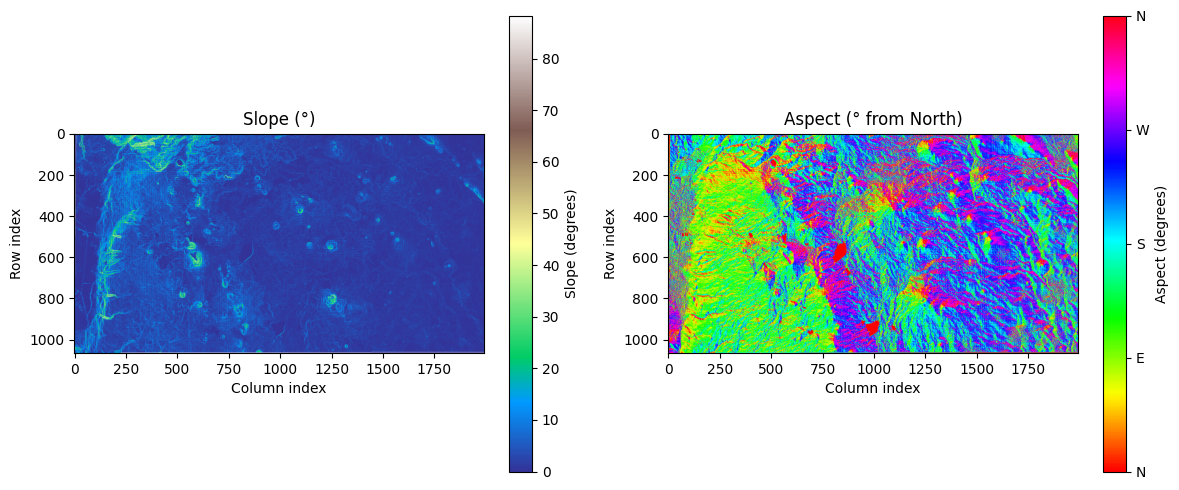

In [5]:
import matplotlib.pyplot as plt

# slope_deg, aspect_deg: (H, W) numpy array

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# -- Slope --
im1 = ax1.imshow(
    slope_deg,
    cmap="terrain",
    origin="upper"       # (0,0)을 좌상단으로
)
ax1.set_title("Slope (°)")
ax1.set_xlabel("Column index")
ax1.set_ylabel("Row index")
plt.colorbar(im1, ax=ax1, label="Slope (degrees)")

# -- Aspect --
im2 = ax2.imshow(
    aspect_deg,
    cmap="hsv",
    origin="upper"
)
ax2.set_title("Aspect (° from North)")
ax2.set_xlabel("Column index")
ax2.set_ylabel("Row index")
cbar = plt.colorbar(im2, ax=ax2, label="Aspect (degrees)")
cbar.set_ticks([0, 90, 180, 270, 360])
cbar.set_ticklabels(["N", "E", "S", "W", "N"])

plt.tight_layout()
plt.show()


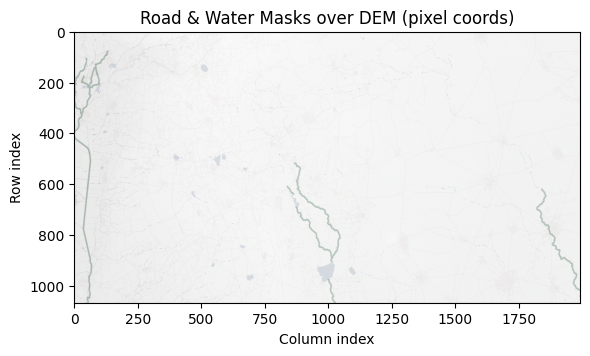

In [6]:
import matplotlib.pyplot as plt

# dem, road_mask, lake_mask, river_mask, stream_mask: (H, W) numpy array

fig, ax = plt.subplots(figsize=(6, 6))

# --- DEM 배경 ---
ax.imshow(
    dem,
    cmap="gray",
    origin="upper"
)

# --- 마스크 오버레이 ---
ax.imshow(
    road_mask,
    cmap="Reds",
    alpha=0.5,
    origin="upper"
)
ax.imshow(
    lake_mask,
    cmap="Blues",
    alpha=0.5,
    origin="upper"
)
ax.imshow(
    river_mask,
    cmap="Greens",
    alpha=0.5,
    origin="upper"
)
ax.imshow(
    stream_mask,
    cmap="Purples",
    alpha=0.5,
    origin="upper"
)

# 픽셀 좌표축 설정
ax.set_xlim(0, dem.shape[1])
ax.set_ylim(dem.shape[0], 0)   # y축 뒤집기
ax.set_xlabel("Column index")
ax.set_ylabel("Row index")
ax.set_title("Road & Water Masks over DEM (pixel coords)")

plt.tight_layout()
plt.show()
